In [1]:
%matplotlib inline

#import malariagen_data
import allel
import malariagen_data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe

In [2]:

inversionDict = {"2La" : ("2L", "karyotype/2La_targets.txt"),
                 "2Rj" : ("2R", "karyotype/2Rj_targets.txt"),
                 "2Rb" : ("2R", "karyotype/2Rb_targets.txt"),
                 "2Rc_col" : ("2R", "karyotype/2Rc_col_targets.txt"),
                 "2Rc_gam" : ("2R", "karyotype/2Rc_gam_targets.txt"),
                 "2Rd" : ("2R", "karyotype/2Rd_targets.txt"),
                 "2Ru" : ("2R", "karyotype/2Ru_targets.txt")}


def import_inversion(inversion):

    '''Load the tag SNPs for the appropriate inversion.'''

    path = inversionDict[inversion][1]
    targets = pd.read_csv(path, header=None).rename(columns={0:'pos'})    
    return targets

def calculate_genotype_at_concordant_sites(callset, targets, haps=False):

    '''Calculate the average number of alternate alleles for each specimen at
    each tag SNP.'''

    bool_ =  np.isin(callset['pos'], targets['pos'])
    genos = callset["geno"].compress(bool_, axis=0)
    if haps == False:
        alt_count = genos.to_n_alt()
    else:
        alt_count = genos
    is_called = genos.is_called()

    av_gts = np.mean(np.ma.MaskedArray(alt_count,
                                       mask=~is_called), axis=0).data
    match_dict = {0: None, 1: None, 2: None}

    for value in [0, 1, 2]:
        n_matches = np.sum(np.ma.MaskedArray(alt_count,
                                             mask=~is_called) == value,
                            axis=0).data
        match_dict[value] = n_matches

    total_sites = np.sum(is_called, axis=0)

    return av_gts, total_sites, match_dict[0], match_dict[1], match_dict[2]
    

def compkaryo(callset, inversion, haps=False):

    '''Extract tag SNPs and desired specimens and calculate the average
    number of alternate alleles.'''

    targets = import_inversion(inversion)

    av_gts, total_sites, num_0, num_1, num_2 = calculate_genotype_at_concordant_sites(callset, targets, haps)

    return av_gts, total_sites, num_0, num_1, num_2
   

### Karyotyping the GAARDIAN and Ag1000g data

In [3]:
ag3 = malariagen_data.Ag3(pre=True)

## compkaryo

In [4]:
my_sample_set = [
    # Ag1000G phase 3 sample sets in Ag3.0
    "AG1000G-GH", 
    'AG1000G-ML-A',
     'AG1000G-BF-A',
     'AG1000G-BF-B',
     'AG1000G-GN-A',
     'AG1000G-GN-B',
    'AG1000G-TZ',
    # Amenta-Etego sample sets in Ag3.3
    # GAARDIAN sample set in Ag3.4
    '1244-VO-GH-YAWSON-VMF00149',
    # GAARD Ghana sample set in Ag3.2
     "1244-VO-GH-YAWSON-VMF00051",
     '1245-VO-CI-CONSTANT-VMF00054',
     '1253-VO-TG-DJOGBENOU-VMF00052',
     '1237-VO-BJ-DJOGBENOU-VMF00050'
]

metadata = ag3.sample_metadata(sample_sets=my_sample_set)

In [5]:
snps = ag3.snp_genotypes(region='2L', sample_sets=my_sample_set)
pos = ag3.snp_sites(region='2L', field='POS')
geno = allel.GenotypeDaskArray(snps)

In [6]:
chrom = '2L'
inversion = '2La'

probe.log("Loading SNP targets...")
targets = pd.read_csv(f"karyotype/{inversion}_targets.txt", sep="\t", header=None)
pos2la = targets[0].to_list()
pos = allel.SortedIndex(pos)
pos_bool = pos.locate_intersection(pos2la)[0]
pos = pos[pos_bool]


geno = allel.GenotypeArray(geno.compress(pos_bool, axis=0))

callset = {'geno':geno, 'pos':pos, 'chrom':chrom}
print(f"--- Running CompKaryo {inversion}--- ")
av_gts, total_sites, num_0, num_1, num_2 = compkaryo(callset, inversion, haps=False)
df = pd.DataFrame({'partner_sample_id': metadata['sample_id'], 
                        'inversion':inversion, 
                        'mean_genotype': av_gts, 
                        'total_snp_tags':total_sites})


Loading SNP targets...
--- Running CompKaryo 2La--- 


In [ ]:
df = pd.DataFrame({'partner_sample_id': metadata['sample_id'], 
                        'inversion':inversion, 
                        'mean_genotype': av_gts, 
                        'total_snp_tags':total_sites})

In [7]:
df.to_csv("../../results/gaard_and_ag3.2la.karyo.tsv", sep="\t")

<AxesSubplot:>

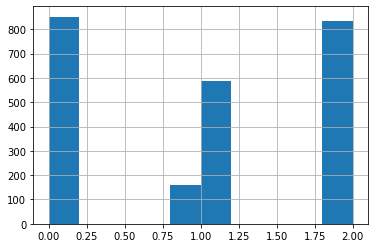

In [8]:
df['mean_genotype'].hist()

In [24]:
metadata['karyo']

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,...,aim_species,country_iso,admin1_name,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin2_year,cohort_admin2_month
0,AA0052-C,Twifo_Praso__F2,David Weetman,Ghana,Twifo Praso,2012,9,5.609,-1.549,F,...,coluzzii,GHA,Central,GH-CP,Twifu Heman/Lower Denkyira,coluzzii,GH-CP_colu_2012,GH-CP_colu_2012_09,GH-CP_Twifu-Heman-Lower-Denkyira_colu_2012,GH-CP_Twifu-Heman-Lower-Denkyira_colu_2012_09
1,AA0103-C,Takoradi_H9,David Weetman,Ghana,Takoradi,2012,8,4.912,-1.774,F,...,coluzzii,GHA,Western,GH-WP,Shama Ahanta East,coluzzii,GH-WP_colu_2012,GH-WP_colu_2012_08,GH-WP_Shama-Ahanta-East_colu_2012,GH-WP_Shama-Ahanta-East_colu_2012_08
2,AA0115-C,Takoradi_A10,David Weetman,Ghana,Takoradi,2012,8,4.912,-1.774,F,...,coluzzii,GHA,Western,GH-WP,Shama Ahanta East,coluzzii,GH-WP_colu_2012,GH-WP_colu_2012_08,GH-WP_Shama-Ahanta-East_colu_2012,GH-WP_Shama-Ahanta-East_colu_2012_08
3,AA0050-C,Madina_E5,David Weetman,Ghana,Madina_West,2012,11,5.668,-0.219,F,...,gambiae,GHA,Greater Accra,GH-AA,Ga East,gambiae,GH-AA_gamb_2012,GH-AA_gamb_2012_11,GH-AA_Ga-East_gamb_2012,GH-AA_Ga-East_gamb_2012_11
4,AA0134-C,Madina_D6,David Weetman,Ghana,Madina_West,2012,11,5.668,-0.219,F,...,coluzzii,GHA,Greater Accra,GH-AA,Ga East,coluzzii,GH-AA_colu_2012,GH-AA_colu_2012_11,GH-AA_Ga-East_colu_2012,GH-AA_Ga-East_colu_2012_11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,VBS19046-5562STDY7801875,WA-1141,Luc Djogbenou,Benin,Avrankou,2017,9,6.550,2.667,F,...,coluzzii,BEN,Ouémé,BJ-OU,Avrankou,coluzzii,BJ-OU_colu_2017,BJ-OU_colu_2017_09,BJ-OU_Avrankou_colu_2017,BJ-OU_Avrankou_colu_2017_09
1642,VBS19047-5562STDY7801876,WA-1142,Luc Djogbenou,Benin,Avrankou,2017,9,6.550,2.667,F,...,coluzzii,BEN,Ouémé,BJ-OU,Avrankou,coluzzii,BJ-OU_colu_2017,BJ-OU_colu_2017_09,BJ-OU_Avrankou_colu_2017,BJ-OU_Avrankou_colu_2017_09
1643,VBS19048-5562STDY7801877,WA-1143,Luc Djogbenou,Benin,Avrankou,2017,9,6.550,2.667,F,...,coluzzii,BEN,Ouémé,BJ-OU,Avrankou,coluzzii,BJ-OU_colu_2017,BJ-OU_colu_2017_09,BJ-OU_Avrankou_colu_2017,BJ-OU_Avrankou_colu_2017_09
1644,VBS19049-5562STDY7801878,WA-1144,Luc Djogbenou,Benin,Avrankou,2017,9,6.550,2.667,F,...,coluzzii,BEN,Ouémé,BJ-OU,Avrankou,coluzzii,BJ-OU_colu_2017,BJ-OU_colu_2017_09,BJ-OU_Avrankou_colu_2017,BJ-OU_Avrankou_colu_2017_09
